In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_statistic as ART_sta

import warnings
warnings.filterwarnings('ignore')

In [2]:
correction1, nameout1, label1 = 'quantile-quantile', 'QQc', 'ISIMIP_QM'

In [4]:
COMPUTERNAME = os.environ['COMPUTERNAME']
print(f'Computer: {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

Computer: UNIPD_DELL


In [7]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join('/','media','arturo','T9','Data','Italy','Rain_Gauges_QC')
bias_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected')

METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [ ]:
# Stations with problems
list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

In [38]:
def get_relative_error_list(product, dir_base, seed, list_remove, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data

    if corrected == True:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}_corrected_{corr_method}_{str(seed).zfill(4)}.h5')
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')

    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    OBS, RAW, DOWN = [], [], []
    RED, REDn = [], []
    RER, RERn = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            OBS_ = data[keys_QUANTILES[nn]].OBS.values[3]
            RAW_ = data[keys_QUANTILES[nn]].SAT_raw.values[3]
            DOWN_ = data[keys_QUANTILES[nn]].SAT_down.values[3]
            RED_ = data[keys_QUANTILES[nn]].RE_down.values[3]
            RER_ = data[keys_QUANTILES[nn]].RE_raw.values[3]

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(OBS_)
            RAW.append(RAW_)
            DOWN.append(DOWN_)
            RED.append(RED_)
            RER.append(RER_)
        else:
            continue

    REDn = (RED - np.nanmin(RED))/(np.nanmax(RED) - np.nanmin(RED))
    RERn = (RER - np.nanmin(RER))/(np.nanmax(RER) - np.nanmin(RER))

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'RAW':RAW, 'DOWN':DOWN, 'RER':RER, 'RERn':RERn, 'RED':RED, 'REDn':REDn})
    DF_DATA.loc[DF_DATA['RER'] > val_max, 'RER'] = np.nan
    DF_DATA.loc[DF_DATA['RER'].isna(), 'RED'] = np.nan

    return DF_DATA

In [40]:
frac = 0.7
seeds = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]

for seed in seeds:
    Q_train_list = []
    Q_val_list = []

    for iso in METADATA['ISO'].unique():
        
        META_iso = METADATA[METADATA['ISO'] == iso]

        # Si una región tiene muy pocas estaciones, evita errores
        if len(META_iso) < 2:
            Q_train_list.append(META_iso)
            continue

        META_80 = META_iso.sample(frac=frac, random_state=seed)
        META_20 = META_iso.drop(META_80.index)

        Q_train_list.append(META_80)
        Q_val_list.append(META_20)

    Q_train = pd.concat(Q_train_list, ignore_index=True)
    Q_val = pd.concat(Q_val_list, ignore_index=True)
    
    Q_val_clean = Q_val[~Q_val['File'].isin(list_remove)].reset_index(drop=True)
    list_Q20 = Q_val_clean.File.values

In [49]:
dir_ =os.path.join(dir_font,'media','arturo','T9','Data','Italy')
DF_IMERG = get_relative_error_list('IMERG', dir_, seed, list_Q20, val_max=1.1, corrected=False, corr_method=nameout1)
DF_CMORPH = get_relative_error_list('CMORPH',dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_MSWEP = get_relative_error_list('MSWEP',dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_ERA5 = get_relative_error_list('ERA5',dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_GSMaP = get_relative_error_list('GSMaP',dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_CHIRPS = get_relative_error_list('CHIRPS',dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_ENSEMBLE_MEAN = get_relative_error_list('ENSEMBLE_ALL_mean', dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)
DF_ENSEMBLE_MEDIAN = get_relative_error_list('ENSEMBLE_ALL_median', dir_, seed, list_Q20, val_max=1.1,corrected=False, corr_method=nameout1)

DF_IMERG_QQc = get_relative_error_list('IMERG', dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_CMORPH_QQc = get_relative_error_list('CMORPH',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_MSWEP_QQc = get_relative_error_list('MSWEP',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_ERA5_QQc = get_relative_error_list('ERA5',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_GSMaP_QQc = get_relative_error_list('GSMaP',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_CHIRPS_QQc = get_relative_error_list('CHIRPS',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_ENSEMBLE_MEAN_QQc = get_relative_error_list('ENSEMBLE_ALL_mean',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)
DF_ENSEMBLE_MEDIAN_QQc = get_relative_error_list('ENSEMBLE_ALL_median',dir_, seed, list_Q20, val_max=1.1, corrected=True, corr_method=nameout1)

In [50]:
RSR_RAW_compare, RSR_DOWN_compare = ART_sta.Statistics_RAW_DOWN(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEAN, DF_ENSEMBLE_MEDIAN)
RSR_RAW_compare_QQc, RSR_DOWN_compare_QQc = ART_sta.Statistics_RAW_DOWN(DF_IMERG_QQc, DF_CMORPH_QQc, DF_MSWEP_QQc, DF_ERA5_QQc, DF_GSMaP_QQc, DF_CHIRPS_QQc, DF_ENSEMBLE_MEAN_QQc, DF_ENSEMBLE_MEDIAN_QQc)

In [52]:
RSR_DOWN_compare

,Dataset,STD,Mean,Median,DIFF,IQR,CORR,MARE
0,IMERG,0.272,0.006,0.007,0.001,0.348,0.603,0.216
1,CMORPH,0.353,0.148,0.136,0.012,0.462,0.450,0.311
2,MSWEP,0.228,-0.233,-0.244,0.011,0.268,0.581,0.277
3,ERA5,0.208,-0.216,-0.210,0.006,0.262,0.602,0.251
4,GSMaP,0.177,-0.397,-0.402,0.005,0.216,0.479,0.422
5,CHIRPS,0.278,-0.188,-0.201,0.013,0.316,0.416,0.275
6,ENSEMBLE MEAN,0.246,-0.181,-0.195,0.014,0.278,0.510,0.252
7,ENSEMBLE MEDIAN,0.194,-0.251,-0.242,0.009,0.231,0.633,0.271


In [53]:
RSR_DOWN_compare_QQc

,Dataset,STD,Mean,Median,DIFF,IQR,CORR,MARE
0,IMERG,0.273,0.007,0.018,0.011,0.371,0.559,0.221
1,CMORPH,0.301,-0.009,-0.002,0.007,0.401,0.443,0.245
2,MSWEP,0.331,0.091,0.078,0.013,0.386,0.539,0.281
3,ERA5,0.282,0.004,0.002,0.002,0.359,0.554,0.224
4,GSMaP,0.332,0.102,0.096,0.006,0.438,0.453,0.288
5,CHIRPS,0.352,0.037,0.021,0.016,0.471,0.402,0.315
6,ENSEMBLE MEAN,0.246,-0.039,-0.026,0.013,0.333,0.626,0.198
7,ENSEMBLE MEDIAN,0.251,-0.022,-0.010,0.012,0.330,0.635,0.199


In [59]:
QUARTILE_IMERG, QUARTILE_IMERG_M = ART_sta.DF_elevation(DF_IMERG)
QUARTILE_CMORPH, QUARTILE_CMORPH_M = ART_sta.DF_elevation(DF_CMORPH)
QUARTILE_MSWEP, QUARTILE_MSWEP_M = ART_sta.DF_elevation(DF_MSWEP)
QUARTILE_ERA5, QUARTILE_ERA5_M = ART_sta.DF_elevation(DF_ERA5)
QUARTILE_GSMaP, QUARTILE_GSMaP_M = ART_sta.DF_elevation(DF_GSMaP)
QUARTILE_CHIRPS, QUARTILE_CHIRPS_M = ART_sta.DF_elevation(DF_CHIRPS)
QUARTILE_ENSEMBLE_MEAN, QUARTILE_ENSEMBLE_MEAN = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN)
QUARTILE_ENSEMBLE_MEDIAN, QUARTILE_ENSEMBLE_MEDIAN = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN)

QUARTILE_IMERG_QQc, QUARTILE_IMERG_M_QQc = ART_sta.DF_elevation(DF_IMERG_QQc)
QUARTILE_CMORPH_QQc, QUARTILE_CMORPH_M_QQc = ART_sta.DF_elevation(DF_CMORPH_QQc)
QUARTILE_MSWEP_QQc, QUARTILE_MSWEP_M_QQc = ART_sta.DF_elevation(DF_MSWEP_QQc)
QUARTILE_ERA5_QQc, QUARTILE_ERA5_M_QQc = ART_sta.DF_elevation(DF_ERA5_QQc)
QUARTILE_GSMaP_QQc, QUARTILE_GSMaP_M_QQc = ART_sta.DF_elevation(DF_GSMaP_QQc)
QUARTILE_CHIRPS_QQc, QUARTILE_CHIRPS_M_QQc = ART_sta.DF_elevation(DF_CHIRPS_QQc)
QUARTILE_ENSEMBLE_MEAN_QQc, QUARTILE_ENSEMBLE_MEAN_QQc = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN_QQc)
QUARTILE_ENSEMBLE_MEDIAN_QQc, QUARTILE_ENSEMBLE_MEDIAN_QQc = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN_QQc)

In [55]:
corr_IMERG = RSR_DOWN_compare.CORR[0]
corr_CMORPH = RSR_DOWN_compare.CORR[1]
corr_MSWEP = RSR_DOWN_compare.CORR[2]
corr_ERA5 = RSR_DOWN_compare.CORR[3]
corr_GSMaP = RSR_DOWN_compare.CORR[4]
corr_CHIRPS = RSR_DOWN_compare.CORR[5]
corr_ENSEMBLE_MEAN = RSR_DOWN_compare.CORR[6]
corr_ENSEMBLE_MEDIAN = RSR_DOWN_compare.CORR[7]

corr_IMERG_QQc = RSR_DOWN_compare_QQc.CORR[0]
corr_CMORPH_QQc = RSR_DOWN_compare_QQc.CORR[1]
corr_MSWEP_QQc = RSR_DOWN_compare_QQc.CORR[2]
corr_ERA5_QQc = RSR_DOWN_compare_QQc.CORR[3]
corr_GSMaP_QQc = RSR_DOWN_compare_QQc.CORR[4]
corr_CHIRPS_QQc = RSR_DOWN_compare_QQc.CORR[5]
corr_ENSEMBLE_MEAN_QQc = RSR_DOWN_compare_QQc.CORR[6]
corr_ENSEMBLE_MEDIAN_QQc = RSR_DOWN_compare_QQc.CORR[7]

In [56]:
IMERG_x, IMERG_y, IMERG_slope = ART_sta.linear_regression(DF_IMERG)
CMORPH_x, CMORPH_y, CMORPH_slope = ART_sta.linear_regression(DF_CMORPH)
MSWEP_x, MSWEP_y, MSWEP_slope = ART_sta.linear_regression(DF_MSWEP)
ERA5_x, ERA5_y, ERA5_slope = ART_sta.linear_regression(DF_ERA5)
GSMaP_x, GSMaP_y, GSMaP_slope = ART_sta.linear_regression(DF_GSMaP)
CHIRPS_x, CHIRPS_y, CHIRPS_slope = ART_sta.linear_regression(DF_CHIRPS)
ENSEMBLE_MEAN_x, ENSEMBLE_MEAN_y, ENSEMBLE_MEAN_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN)
ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, ENSEMBLE_MEDIAN_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN)

IMERG_QQc_x, IMERG_QQc_y, IMERG_QQc_slope = ART_sta.linear_regression(DF_IMERG_QQc)
CMORPH_QQc_x, CMORPH_QQc_y, CMORPH_QQc_slope = ART_sta.linear_regression(DF_CMORPH_QQc)
MSWEP_QQc_x, MSWEP_QQc_y, MSWEP_QQc_slope = ART_sta.linear_regression(DF_MSWEP_QQc)
ERA5_QQc_x, ERA5_QQc_y, ERA5_QQc_slope = ART_sta.linear_regression(DF_ERA5_QQc)
GSMaP_QQc_x, GSMaP_QQc_y, GSMaP_QQc_slope = ART_sta.linear_regression(DF_GSMaP_QQc)
CHIRPS_QQc_x, CHIRPS_QQc_y, CHIRPS_QQc_slope = ART_sta.linear_regression(DF_CHIRPS_QQc)
ENSEMBLE_MEAN_QQc_x, ENSEMBLE_MEAN_QQc_y, ENSEMBLE_MEAN_QQc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN_QQc)
ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, ENSEMBLE_MEDIAN_QQc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN_QQc)

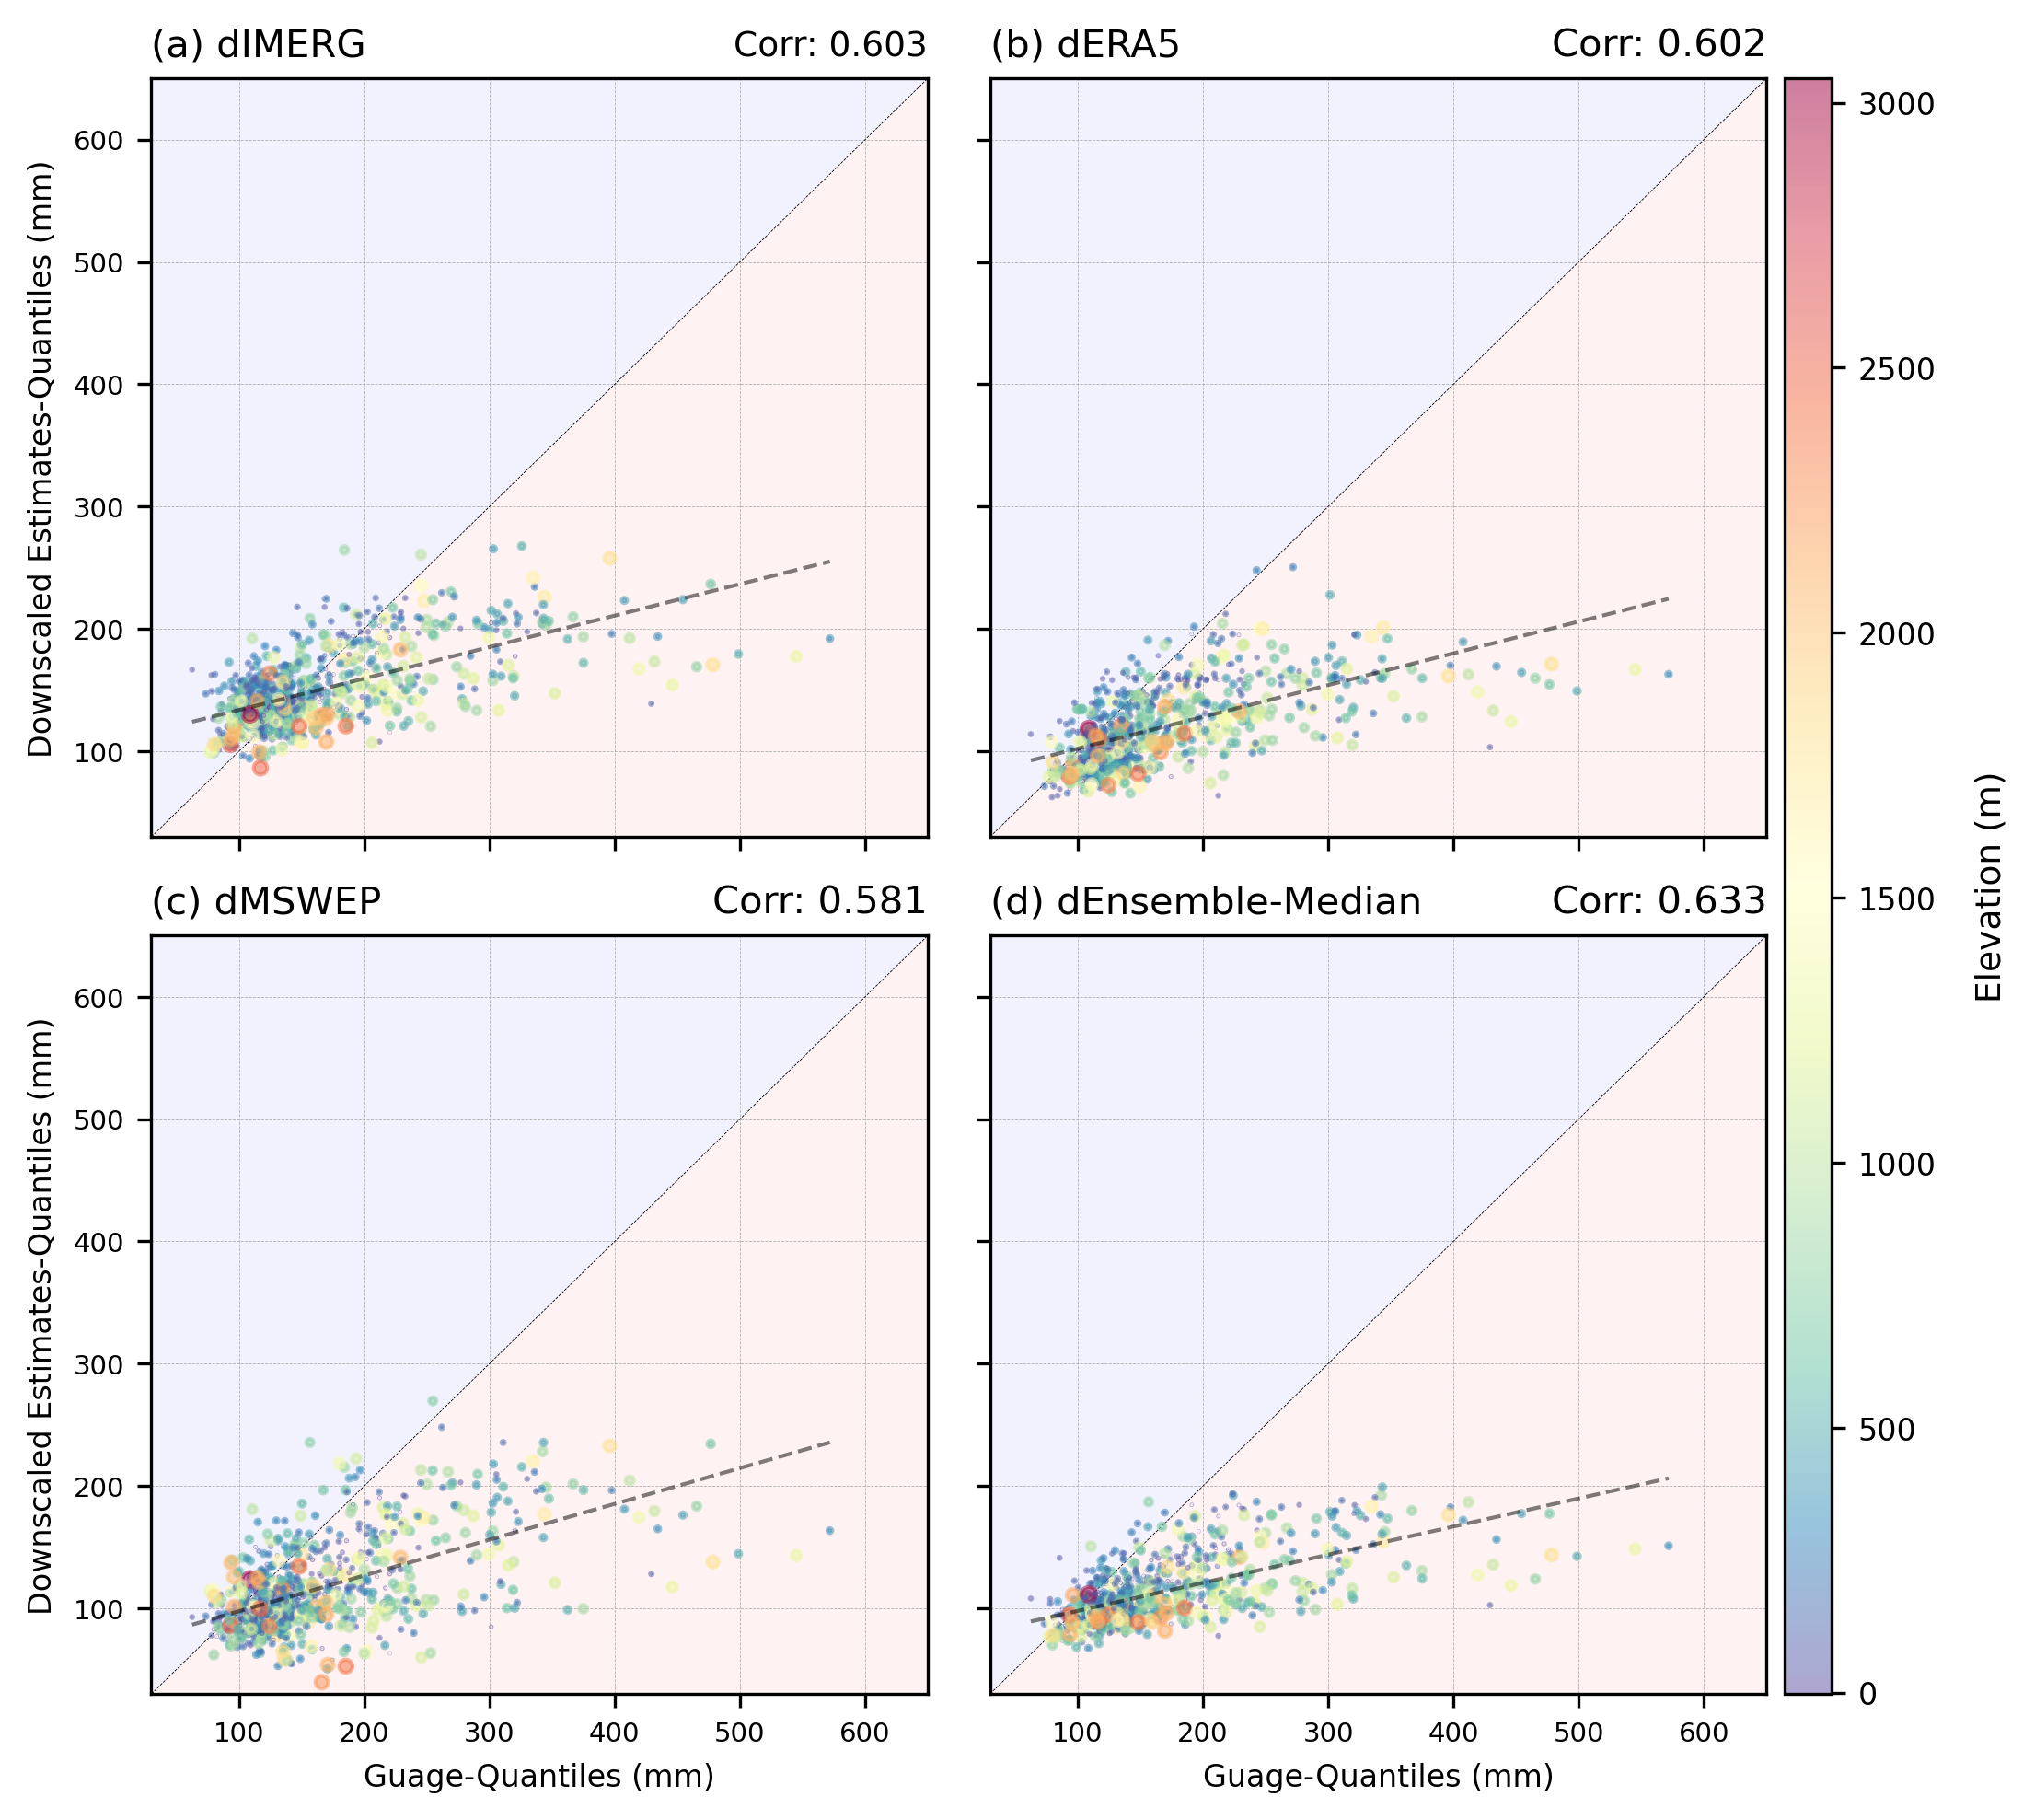

In [ ]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG.ELEV.min()
vmax = DF_IMERG.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG.OBS, DF_IMERG.DOWN,
    alpha=0.5,
    s=DF_IMERG.ELEVn*15,
    c=DF_IMERG.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5.OBS, DF_ERA5.DOWN,
    alpha=0.5,
    s=DF_ERA5.ELEVn*15,
    c=DF_ERA5.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP.OBS, DF_MSWEP.DOWN,
    alpha=0.5,
    s=DF_MSWEP.ELEVn*15,
    c=DF_MSWEP.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_Validation.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

../figures/Article_down/Scatter_FOCUS_validation_corected.png


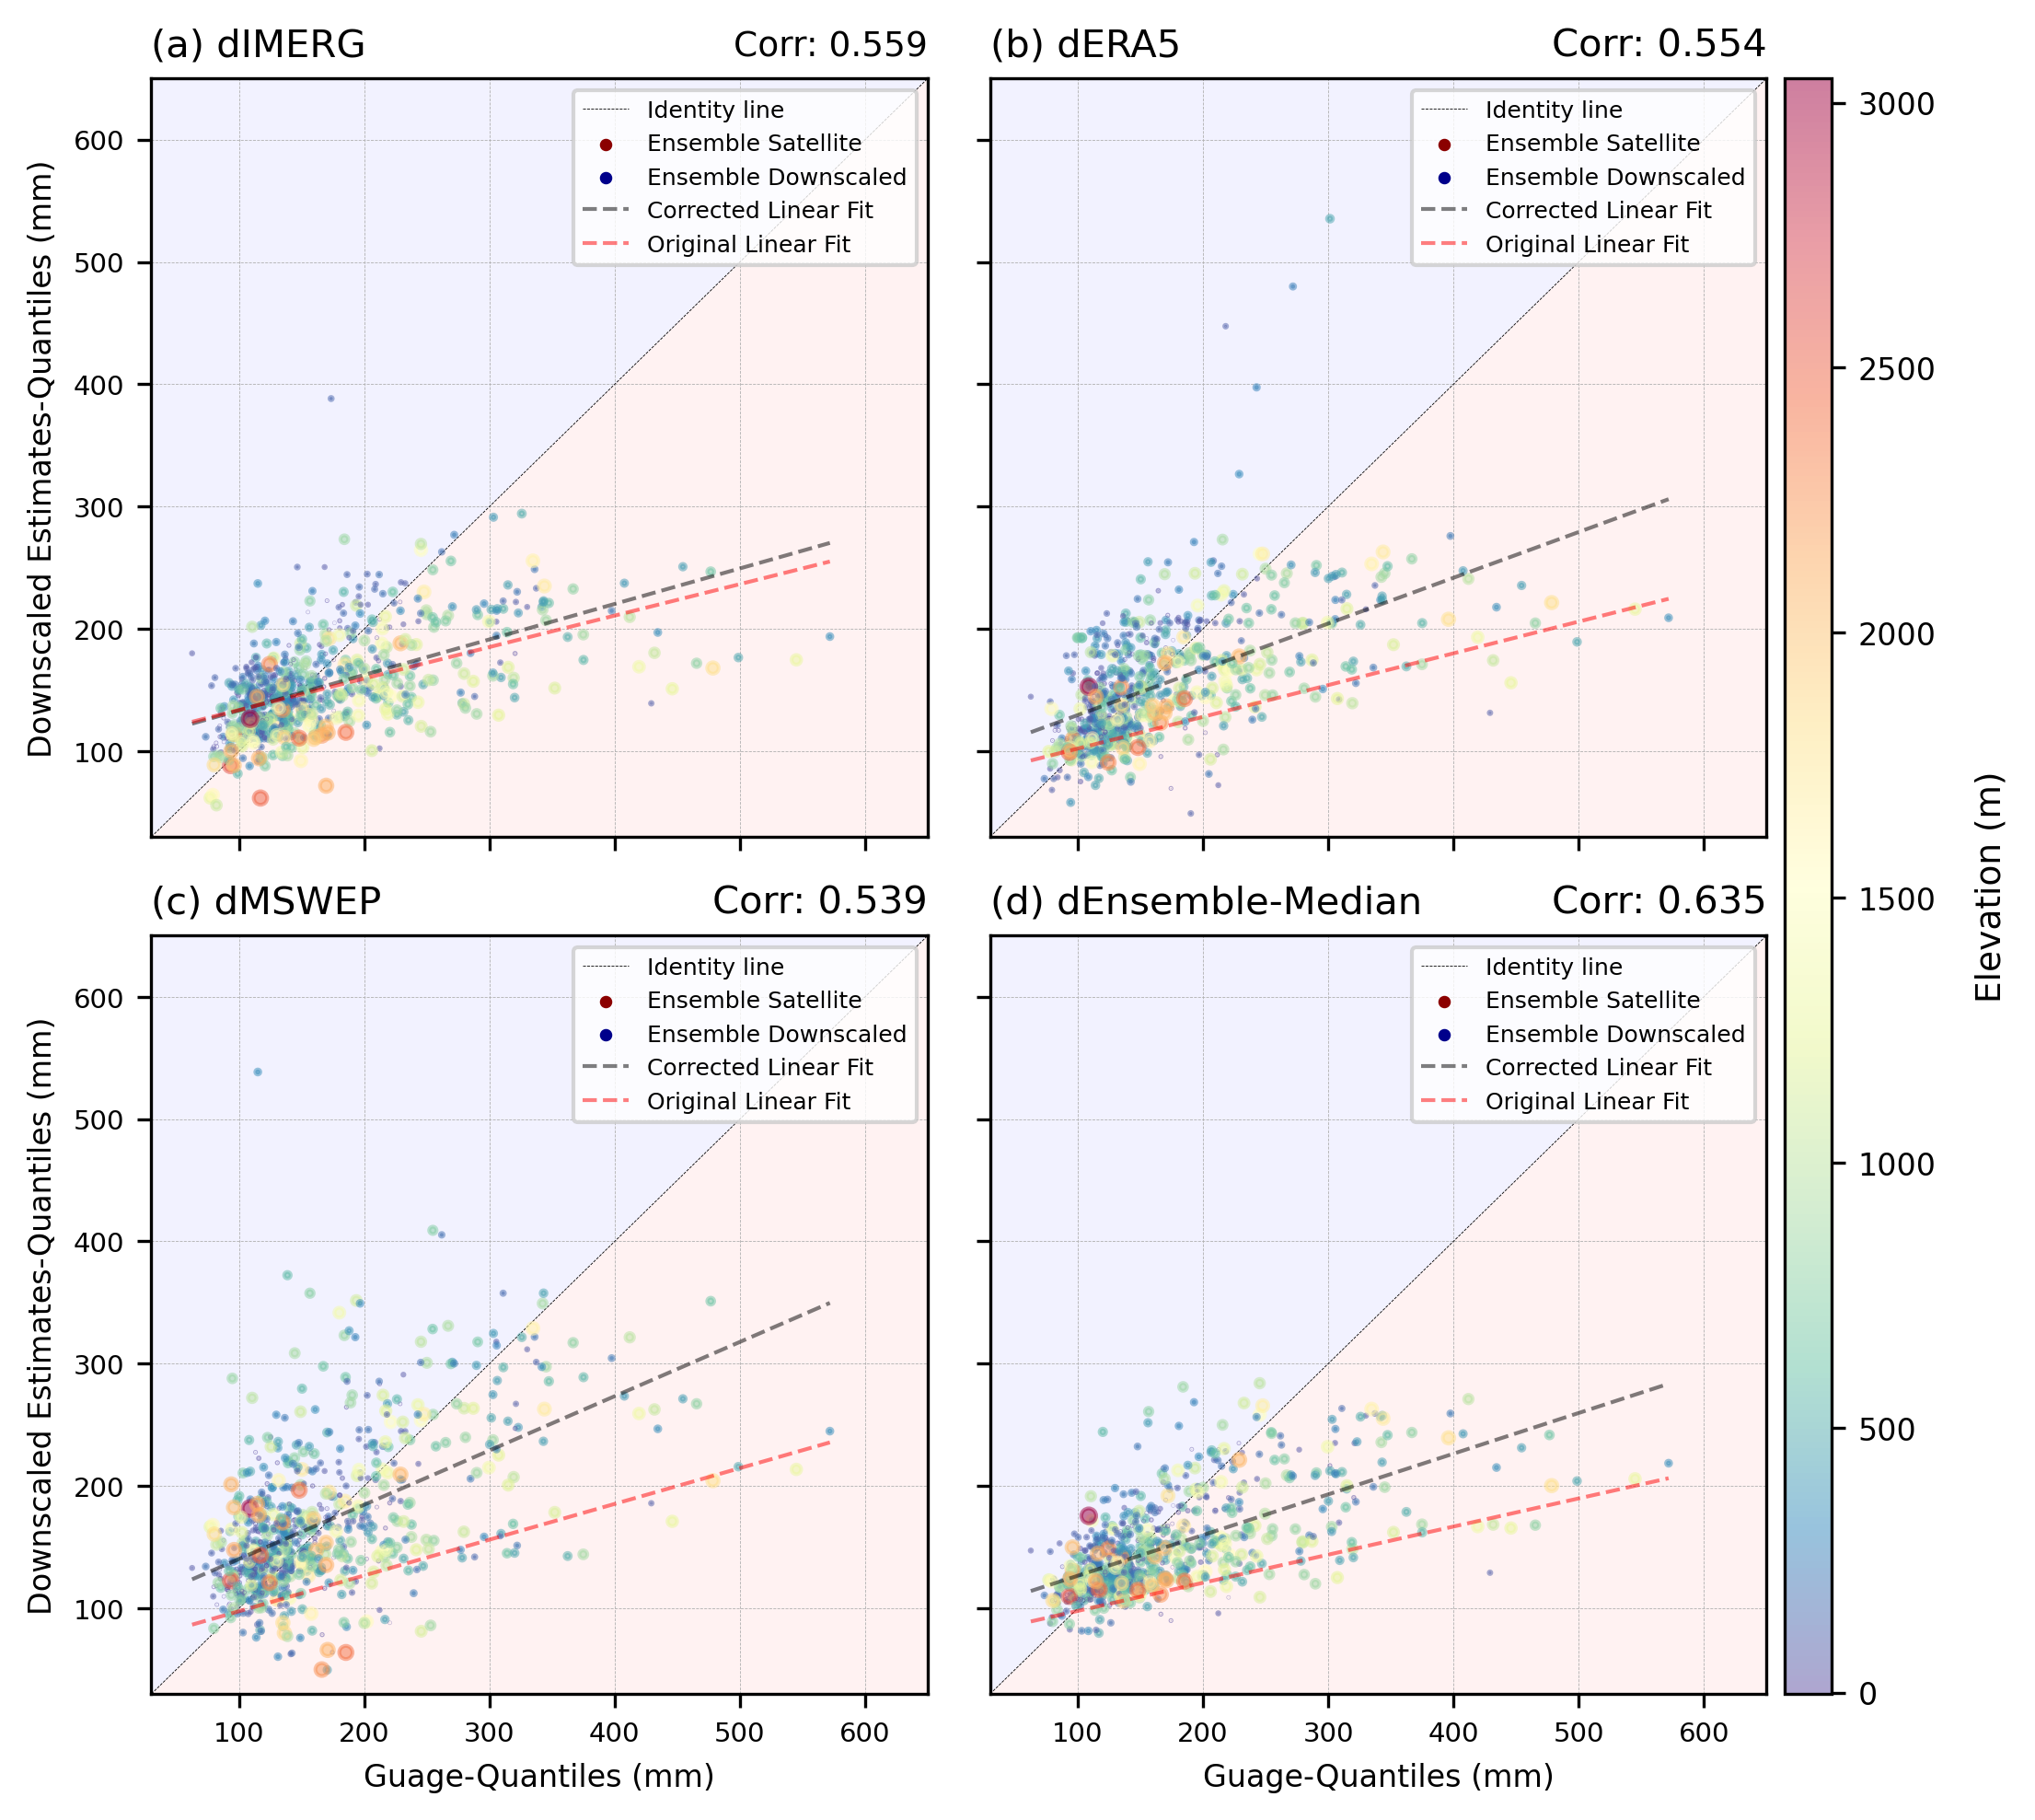

In [69]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG.ELEV.min()
vmax = DF_IMERG.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG_QQc.OBS, DF_IMERG_QQc.DOWN,
    alpha=0.5,
    s=DF_IMERG_QQc.ELEVn*15,
    c=DF_IMERG_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_QQc_x, IMERG_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_QQc}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5_QQc.OBS, DF_ERA5_QQc.DOWN,
    alpha=0.5,
    s=DF_ERA5_QQc.ELEVn*15,
    c=DF_ERA5_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_QQc_x, ERA5_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP_QQc.OBS, DF_MSWEP_QQc.DOWN,
    alpha=0.5,
    s=DF_MSWEP_QQc.ELEVn*15,
    c=DF_MSWEP_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_QQc_x, MSWEP_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN_QQc.OBS, DF_ENSEMBLE_MEDIAN_QQc.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN_QQc.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Original Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Original Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Original Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Original Linear Fit", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

salida = '../figures/Article_down/Scatter_FOCUS_validation_corected.png'
print(salida)
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [89]:
datasets_keep = ['IMERG', 'ERA5', 'MSWEP', 'ENSEMBLE MEDIAN']

RSR_DOWN_compare_filter = RSR_DOWN_compare[RSR_DOWN_compare['Dataset'].isin(datasets_keep)].reset_index(drop=True)
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('IMERG','dIMERG')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('MSWEP','dMSWEP')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('ERA5','dERA5')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median')

RSR_DOWN_compare_QQc_filter = (RSR_DOWN_compare_QQc[RSR_DOWN_compare_QQc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('IMERG','dIMERG corrected')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('MSWEP','dMSWEP corrected')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('ERA5','dERA5 corrected')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median corrected')


In [92]:
RSR_ALL = pd.concat(
    [RSR_DOWN_compare_filter, RSR_DOWN_compare_QQc_filter],
    axis=0,
    ignore_index=True
)

In [96]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']
colors_T = [colors[0], colors[2], colors[3], 'k', colors[0], colors[2], colors[3], 'k']
markers_T = ['o', 'o', 'o', 'o', 's', 's', 's', 's']

In [93]:
RSR_ALL

,Dataset,STD,Mean,Median,DIFF,IQR,CORR,MARE
0,dIMERG,0.272,0.006,0.007,0.001,0.348,0.603,0.216
1,dMSWEP,0.228,-0.233,-0.244,0.011,0.268,0.581,0.277
2,dERA5,0.208,-0.216,-0.210,0.006,0.262,0.602,0.251
3,dEnsemble-Median,0.194,-0.251,-0.242,0.009,0.231,0.633,0.271
4,dIMERG corrected,0.273,0.007,0.018,0.011,0.371,0.559,0.221
5,dMSWEP corrected,0.331,0.091,0.078,0.013,0.386,0.539,0.281
6,dERA5 corrected,0.282,0.004,0.002,0.002,0.359,0.554,0.224
7,dEnsemble-Median corrected,0.251,-0.022,-0.010,0.012,0.330,0.635,0.199


../figures/Article_down/Scatter_FOCUS_RE_corected.png


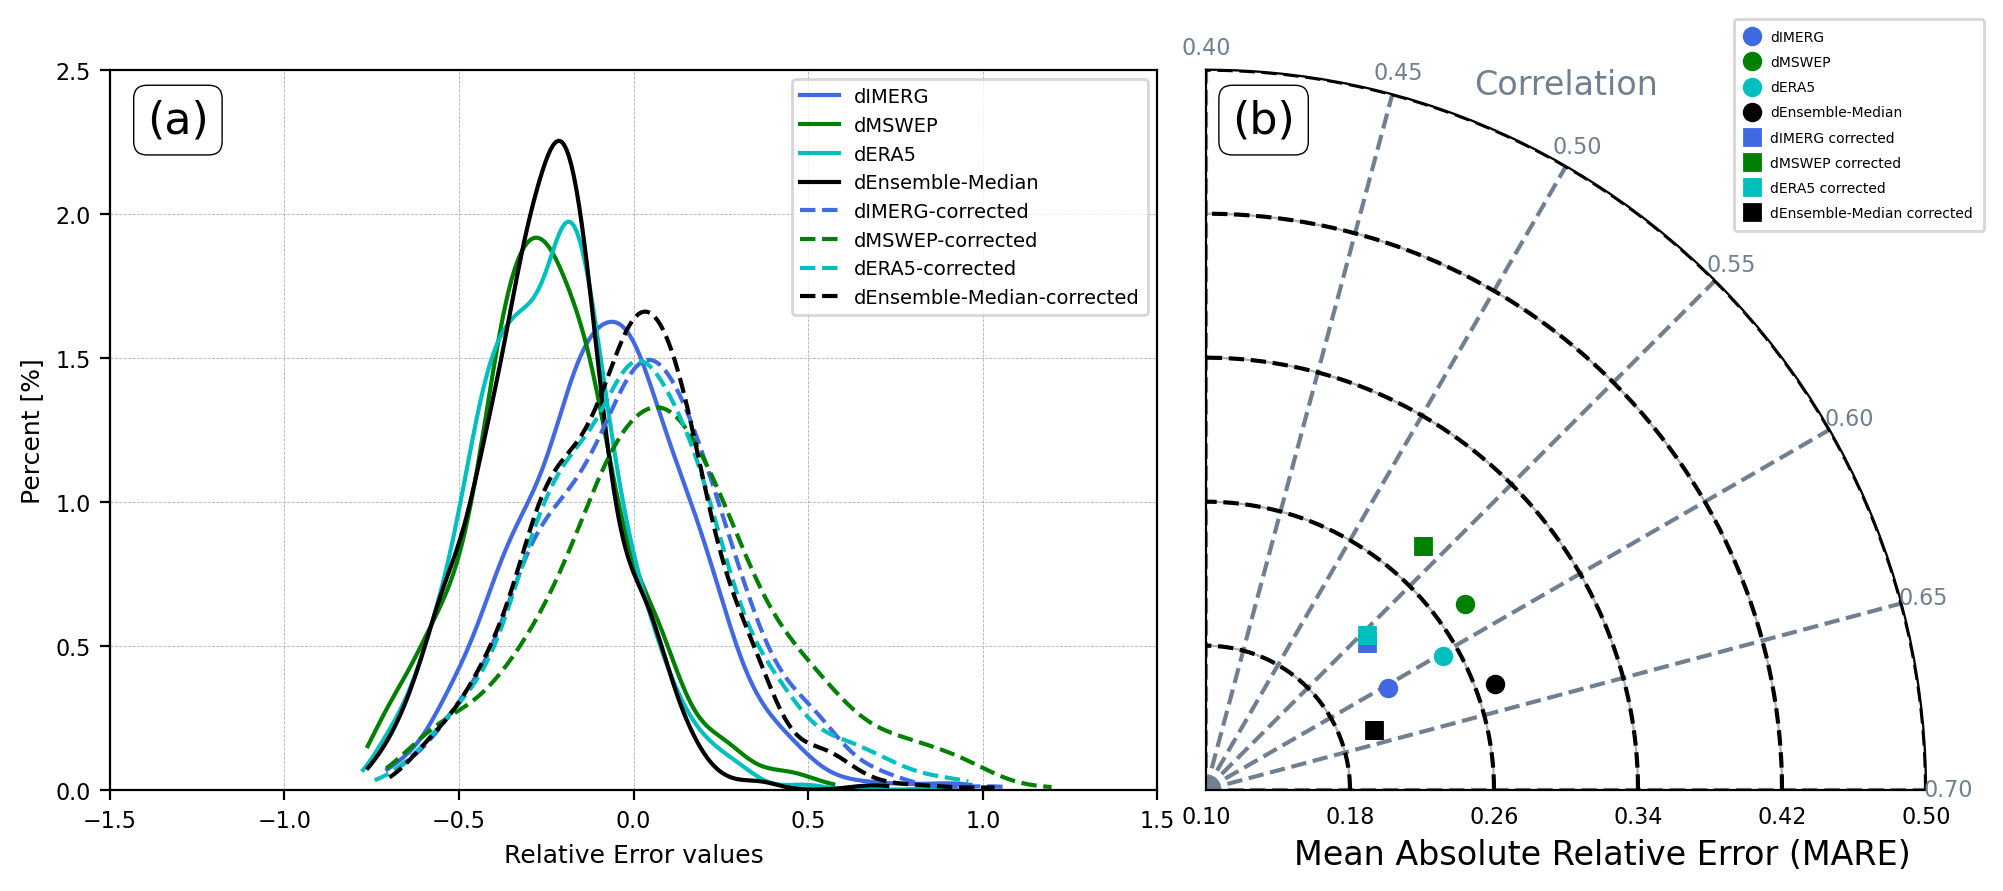

In [113]:
fig = plt.figure(figsize=(11,4),dpi=200)
gs = gridspec.GridSpec(1,2)

# ==========================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_QQc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-corrected',
            clip=(np.nanmin(np.array(DF_IMERG_QQc.RED)), np.nanmax(np.array(DF_IMERG_QQc.RED))))
sns.kdeplot(DF_MSWEP_QQc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-corrected',
            clip=(np.nanmin(np.array(DF_MSWEP_QQc.RED)), np.nanmax(np.array(DF_MSWEP_QQc.RED))))
sns.kdeplot(DF_ERA5_QQc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-corrected',
            clip=(np.nanmin(np.array(DF_ERA5_QQc.RED)), np.nanmax(np.array(DF_ERA5_QQc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_QQc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-corrected',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED))))

ax1.set_ylabel('Percent [%]',fontsize=9)
ax1.set_xlabel('Relative Error values',fontsize=9)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(a)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.7
correlations = np.arange(0.4, 0.75, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_ALL.MARE.values, RSR_ALL.CORR.values, RSR_ALL.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=6, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,
        ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(b)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=-0.11, hspace=-0.2)

salida = '../figures/Article_down/Scatter_FOCUS_RE_corected.png'
print(salida)
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)